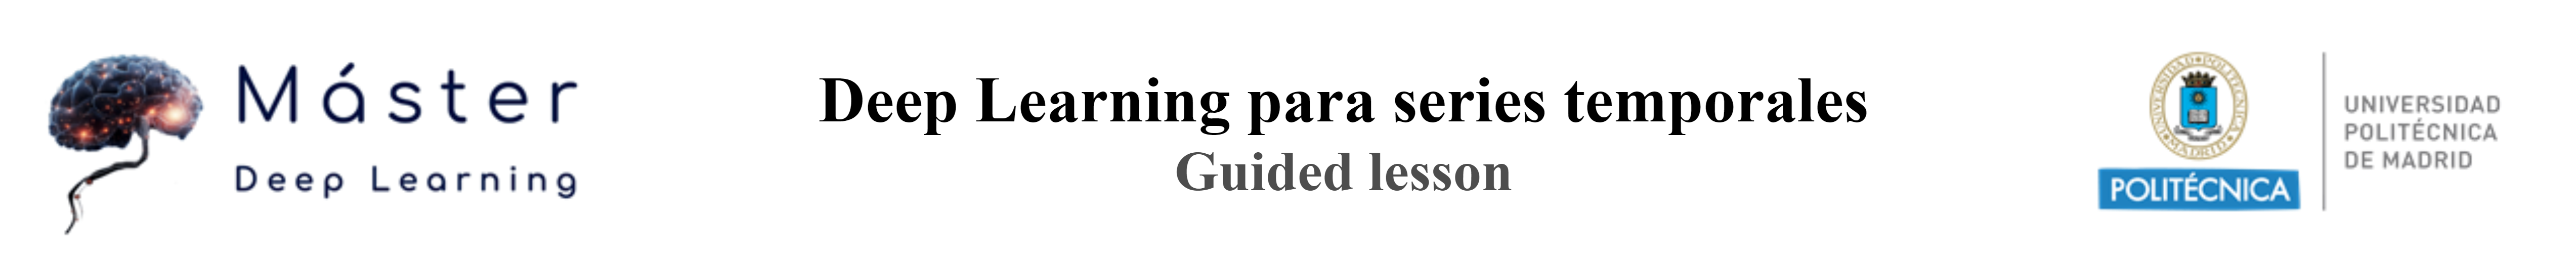

# Time Series | Part II: Preprocessing and analysis
The focus in this part is on:
- Extracting the dataset
- Taking and eye in the main charasteristics of the data
- Loading the dataset to our database

In [ ]:
#! pip install aeon
#! pip install "pydantic<2" --force-reinstall
#! pip install pandas_profiling
#! pip install ydata_profiling
# --- Saving as pdf libraries
#! pip install pypandoc
#! pip install pandoc
#! apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
#!apt-get install pandoc

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport --> Deprecated
import ydata_profiling as ydp

## ETL [Extract - Transform - Load]


### Extract
Let's take a look to Vallecas' air quality: [Calidad del aire. Datos desde 2001.  Portal de datos abiertos del Ayuntamiento de Madrid](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default).

#### Download

In [ ]:
url = 'https://datos.madrid.es/egob/catalogo/201200-10306320-calidad-aire-horario.zip'
! wget {url}

#### Check format
- **Q**: Can we open de file? Is it tsf/csv/feather...? If not... does the origin specify an API or any instruction (kaggle, HuggingFace)?
- **A**: The downloaded file is a '.zip'. Let's unzip it and take a look.

In [ ]:
! unzip 201200-10306320-calidad-aire-horario.zip

- **Q**: Now, what type of file contains the compressed file?
- **A**: `.txt`, `.xml` `.csv`
- **Q**: Are they all useful or do they look similar?


In [ ]:
! ls Anio24

#### Unify data

- **A**: Same file, different extension
- **Q**: Which one can we work with in an easier way?
- **A**: `.csv`

Delete all extra information we don't need and check

In [ ]:
! rm -f Anio24/*txt
! rm -f Anio24/*xml
! ls Anio24

- **Q**: ...but... how is the date saved? Why do we have various files?
- **A**: Seems to be one file per month

- **Q**: Thus... we need to join them. How should we join the files? Let's open two of the files to ckeck

Join all parts

In [ ]:
! cat Anio24/ene_mo24.csv

It has table format... let's read with pandas for better view

In [ ]:
# Prepare next readings, we never know if we may get back for more data
months=["ene", "feb", "mar", "abr", "may", "jun", "jul", "ago", "sep","oct", "nov", "dic"]
year=24
# Read the dataset
air_quality_ds = pd.read_csv(
    filepath_or_buffer = f"./Anio{year}/{months[0]}_mo{year}.csv",
    delimiter = ";",
    header = 0,
    index_col = None,
    usecols = None
    #dtype = float --> We don't know still the data types!!
)

In [ ]:
air_quality_ds.head()

Observe the date is on the columns
ANO -> Year
MES -> Month
DIA -> Day
Thus, we should not have problems on joining all dataFrames in one single dataFrame.

In [ ]:
#months=["ene", "feb", "mar", "abr", "may", "jun", "jul", "ago", "sep","oct", "nov", "dic"]
#years = [24]
#air_quality_ds = None
#for year in years:
#  for month in months:
#    air_quality_ds_ = pd.read_csv(
#      filepath_or_buffer = f"./Anio{year}/{month}_mo{year}.csv",
#      delimiter = ";",
#      header = 0,
#      index_col = None,
#      usecols = None
#      #dtype = float
#    )
#    if month == "ene":
#      air_quality_ds = air_quality_ds_
#    else:
#      pd.concat([air_quality_ds, air_quality_ds_])
#print(air_quality_ds.shape)
#air_quality_ds.head()

Ops! No november... Neither dic... check in local..
In fact... no november gived! No december! ... of course... today is 1/12, too early! Fix the months list!

In [ ]:
months=["ene", "feb", "mar", "abr", "may", "jun", "jul", "ago", "sep","oct"]
years = [24]
air_quality_ds = None
for year in years:
  for month in months:
    air_quality_ds_ = pd.read_csv(
      filepath_or_buffer = f"./Anio{year}/{month}_mo{year}.csv",
      delimiter = ";",
      # header = 0,
      index_col = None,
      usecols = None
    )
    if month == "ene":
      air_quality_ds = air_quality_ds_
    else:
      pd.concat([air_quality_ds, air_quality_ds_])
print(air_quality_ds.shape)
air_quality_ds.head()

### Transform
We got the dataset, but...
- Does it look like a time series?
- Does it have duplicated information?
- Do I need the full dataset?
- What datatype shoul each column be treated as?
- How do I filter for 'Vallecas'?

#### Look to de data... and documentation
- What do the columns name say? Are they self-explicative?
- What do the docs say?



In [ ]:
air_quality_ds.columns

Check [Datos Madrid | Dataset description](https://datos.madrid.es/FWProjects/egob/Catalogo/MedioAmbiente/Aire/Ficheros/Interprete_ficheros_%20calidad_%20del_%20aire_global.pdf)

- PROVINCIA: we want to check 'Madrid'
- MUNICIPIO: we want to focus on 'Madrid'
- ESTACION: we want to focus on 'Vallecas'
- MAGNITUD: We want each magnitude to be a column
- PUNTO_MUESTREO: let's tale a look and decide 1 if needed (technique used)
- V*: Validation code
- H*: Hour -> Must be part of  the date

##### Delete extra information
- Delete columns with just one value (use `np.unique` for checking)
- Filter by Vallecas (Municipio = Madrid, Provincia = Madrid, ESTACION + CODE = Ver código)


In [ ]:
vallecas_code = "28079040"

In [ ]:
np.unique(air_quality_ds["PROVINCIA"].values)

In [ ]:
np.unique(air_quality_ds["MUNICIPIO"].values)

In [ ]:
np.unique(air_quality_ds["ESTACION"].values)

In [ ]:
air_quality_ds.drop(columns='PROVINCIA', inplace=True) #Inplace = Don't make ca copy

##### Process the columns with multiple information

PUNTO_MUESTREO has 3 data in one column... and one is the one we need to filter by...
- Split it using `str.split(separator, expand = True)`
- Check the result displying the head

In [ ]:
print(np.unique(air_quality_ds["PUNTO_MUESTREO"].values)[:3])
# Dividir la columna 'PUNTO_MUESTREO' en tres nuevas columnas
air_quality_ds[['ESTACION_code', 'ESTACION_magnitud', 'ESTACION_technique']] = air_quality_ds['PUNTO_MUESTREO'].str.split('_', expand=True)
# Verificar el resultado
print(display(air_quality_ds.head()))


##### Continue filtering and deleteing unneccesary information and duplicates

- Filter by Vallecas using the station code.
- Check the filtering by showing the unique values
- Continue cleaning

In [ ]:
print(np.unique(air_quality_ds["ESTACION_code"])[:4])
air_quality_ds_vallecas = air_quality_ds.loc[air_quality_ds["ESTACION_code"] == vallecas_code]
print(np.unique(air_quality_ds_vallecas["ESTACION_code"])[:4])

In [ ]:
air_quality_ds_vallecas.drop(columns='ESTACION_code', inplace=True)

Continue droping all unneccesary columns

In [ ]:
air_quality_ds_vallecas.drop(columns = "PUNTO_MUESTREO", inplace = True)
#print(air_quality_ds_vallecas.columns)
#print(np.unique(air_quality_ds_vallecas["MUNICIPIO"]))
air_quality_ds_vallecas.drop(columns = "MUNICIPIO", inplace = True)
#print(np.unique(air_quality_ds_vallecas["ESTACION"]))
air_quality_ds_vallecas.drop(columns = "ESTACION", inplace = True)
#print(np.unique(air_quality_ds_vallecas["MAGNITUD"]))
#all_match = (air_quality_ds["MAGNITUD"] == air_quality_ds["ESTACION_magnitud"]).all()
#print(all_match)
air_quality_ds["ESTACION_magnitud"] = air_quality_ds["ESTACION_magnitud"].astype(int)
#mismatch = air_quality_ds[air_quality_ds["MAGNITUD"] != air_quality_ds["ESTACION_magnitud"]]
air_quality_ds_vallecas.drop(columns = "ESTACION_magnitud", inplace = True)
#print(np.unique(air_quality_ds_vallecas[["MAGNITUD", "ESTACION_technique"]].astype(int), axis = 0))
# We are not gonna take into account the technique, and it seems to be only one technique for magnitude. Thus, we can delete that column
air_quality_ds_vallecas.drop(columns="ESTACION_technique", inplace=True)

display(air_quality_ds_vallecas.head())

##### Index formating

Now we have three problems:

- We want date to be the index
- We want magnitude to be the column
- What do we do with validation ?

- We need H* to be a row V* to be a single column V
- We need MAGNITUD to be a column MAGNITUD-K
- ... Validation says if the data is valid or not. We don't want invalid data! Lets put a NaN where a 'V' is found

In [ ]:
air_quality_ds_vallecas.loc[:, "ANO"] = air_quality_ds_vallecas["ANO"].astype(int)
air_quality_ds_vallecas.loc[:, "MES"] = air_quality_ds_vallecas["MES"].astype(int)
air_quality_ds_vallecas.loc[:, "DIA"] = air_quality_ds_vallecas["DIA"].astype(int)
air_quality_ds_vallecas.loc[:,"DATE"] = pd.to_datetime(
    air_quality_ds_vallecas[["ANO", "MES", "DIA"]].rename(columns={"ANO": "year", "MES": "month", "DIA": "day"})
)
air_quality_ds_vallecas.drop(columns=["ANO", "MES", "DIA"], inplace = True)
display(air_quality_ds_vallecas)

**Alert**

When making big conversions (if it fits in memory) make a copy to ensure you can go back an step.

In [ ]:
df = air_quality_ds_vallecas.copy() #Take care in this part
display(df.head())

In [ ]:
# Come here to restore if needed
air_quality_ds_vallecas = df.copy()
air_quality_ds_vallecas.head()

First step: 'V' => Valid other => not valid => NaN

In [ ]:
hs = [f"H{str(i).zfill(2)}" for i in range(1, 25)]
vs = [f"V{str(i).zfill(2)}" for i in range(1, 25)]
for h, v in zip(hs, vs):
    air_quality_ds_vallecas.loc[air_quality_ds_vallecas[v] != "V", h] = np.nan

Second step: Hours to rows -> Use `melt`

In [ ]:
# Hours to rows
melted = air_quality_ds_vallecas.melt(
    id_vars=["DATE", "MAGNITUD"],
    value_vars=hs,
    var_name="HORA",
    value_name="VALOR"
)
melted.loc[:, "HORA"] = melted["HORA"].str.replace("H", "").astype(int)
melted.loc[:, "HORA"] = pd.to_timedelta(melted["HORA"], unit="h", errors="coerce")
print(melted["DATE"].dtype)  # Should print datetime64[ns]

Third step: Join Date + Hour to get the timestamps and drop Hour extra column

In [ ]:
# Ensure DATE is explicitly converted to datetime64 format
melted.loc[:, "DATE"] = pd.to_datetime(melted["DATE"], errors="coerce")
print(melted["HORA"].dtype)  # Should output: timedelta64[ns]
# Add the timedelta to DATE (this should now work properly)
melted.loc[:, "DATE"] = melted["DATE"] + melted["HORA"]
display(melted.head())

In [ ]:
# Drop 'HORA'
melted.drop(columns=["HORA"], inplace=True)

Four step: convert magnitudes from rows to columns
- Generate a column with explicative laved for each magnitude by adding a header 'MAGNITUD_' to 'MAGNITUD'. Use 'MAGNITUD' column `astype` str.

In [ ]:
# Generate explicative labels
melted["MAGNITUD_LABEL"] = "MAGNITUD_" + melted["MAGNITUD"].astype(str)
# Pivot
result = melted.pivot_table(
    index="DATE",              # Usar la fecha completa (DATE) como índice
    columns="MAGNITUD_LABEL",  # Cada valor de MAGNITUD será una columna
    values="VALOR",            # Los valores medidos irán en las celdas
    aggfunc="first"            # Si hay duplicados, se toma el primero
)

display(result.head())

Take a look to Magnitud 10... something strange, no?

In [ ]:
display(result[result["MAGNITUD_10"].notna()].head())


It is only read at 01:00! Nothing to worry about... but check how to handle this missing values... that's future!

In [ ]:
air_quality_ds_vallecas = result.copy()

##### EDA

Now that the dataframe is under control...
Let's start with the EDA

Plotting the vars sepparated and toguether

In [ ]:
air_quality_ds_vallecas.plot( figsize = (10, 4))

In [ ]:
def plot_var(df, var):
  ax = df.plot(y = var, figsize = (10, 4))
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plot_var(air_quality_ds_vallecas, 'MAGNITUD_10')
plot_var(air_quality_ds_vallecas, 'MAGNITUD_12')
plot_var(air_quality_ds_vallecas, 'MAGNITUD_7')
plot_var(air_quality_ds_vallecas, 'MAGNITUD_8')

Use this function to plot with two different scales

In [ ]:
def plot_with_multiple_secondary_y(df, primary_vars, secondary_vars, figsize=(12, 6)):
    """
    Plots multiple variables with different scales on primary and secondary y-axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - primary_vars (list): Variables to plot on the primary y-axis.
    - secondary_vars (list): Variables to plot on the secondary y-axis.
    - figsize (tuple): Size of the figure.

    Returns:
    - None: Displays the plot.
    """
    ax = df[primary_vars + secondary_vars].plot(
        secondary_y=secondary_vars, figsize=figsize
    )
    ax.set_title("Variables with Primary and Secondary Axes")
    plt.show()

In [ ]:
plot_with_multiple_secondary_y(
    air_quality_ds_vallecas, primary_vars=["MAGNITUD_10", "MAGNITUD_12"], secondary_vars=["MAGNITUD_7", "MAGNITUD_8"]
)

Magnitude 10 still two small for comparing. Let's take more insights using the profile.


In [ ]:

air_quality_ds_vallecas = result.copy()
# Crear el perfil para el DataFrame 'result'
profile = ydp.ProfileReport(air_quality_ds_vallecas, title="Pandas Profiling Report for 'air_quality_ds_vallecas'", explorative=True)

# Mostrar el reporte en el notebook
profile.to_notebook_iframe()

# (Opcional) Guardar el reporte como un archivo HTML
profile.to_file("result_profile_report.html")


## Missing data

### Missing data example I

In [ ]:
# Synthetic dataset random data
np.random.seed(42)  # For reproducibility
n_points = 1000
dataset = pd.DataFrame({
    "Random_Variable": np.random.normal(0, 1, n_points)  # Random normal data
})
# Introduce missing values at random positions (1% missing)
missing_mask = np.random.random(dataset.shape) < 0.01
mv_dataset = dataset.mask(missing_mask, other=pd.NA)

In [ ]:
plt.figure(figsize=(12, 6))

# Function approximation to the time series
plt.plot(dataset.index, dataset["Random_Variable"], color="gray", alpha=0.3, label="Reference Line")

# Filled time series (only available values before filling NaNs)
plt.scatter(mv_dataset.index, mv_dataset["Random_Variable"], label="Data with Missing Values",
            color="orange", alpha=0.8, marker='o', s=10)

# Missing values (before filling) - Vertical lines indicating missing points
nan_indices = np.where(missing_mask)[0]
plt.vlines(nan_indices, ymin=dataset["Random_Variable"].min(), ymax=dataset["Random_Variable"].max(),
           colors='red', linestyles='dashed', alpha=0.5, label="Missing Data Locations")

plt.title("Random Variable: Original vs Missing Values (Before Filling)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# Zooming into a specific range
zoom_range = slice(75, 200)
plt.figure(figsize=(12, 6))

# Function approximation to the time series (reference line)
plt.plot(dataset.index[zoom_range], dataset["Random_Variable"][zoom_range], color="gray", alpha=0.3, label="Reference Line")

# Filled time series (only available values before filling NaNs)
plt.scatter(mv_dataset.index[zoom_range], mv_dataset["Random_Variable"][zoom_range],
            label="Data with Missing Values", color="orange", alpha=0.8, marker='o', s=10)

# Missing values (before filling) - Vertical lines indicating missing points
nan_indices_zoom = nan_indices[nan_indices < 200]  # Filter NaN indices within the zoom range
plt.vlines(nan_indices_zoom, ymin=dataset["Random_Variable"].min(), ymax=dataset["Random_Variable"].max(),
           colors='red', linestyles='dashed', alpha=0.5, label="Missing Data Locations")

plt.title("Zoom: Random Variable with Missing Values (Before Filling)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# Step 2: Rolling mean imputation
# Fill missing values with the rolling mean (window=50)
mv_dataset["Random_Variable_Imputed"] = mv_dataset["Random_Variable"].fillna(
    mv_dataset["Random_Variable"].rolling(window=50, min_periods=1).mean()
)

In [ ]:
# Step 3: Compare the variable with/without missing values using discrete points
plt.figure(figsize=(12, 6))

# Light background reference line to show the overall time series shape
plt.plot(dataset.index, dataset["Random_Variable"], color="gray", alpha=0.3, label="Reference Line")

# Original data points (excluding imputed values)
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["Random_Variable"][~missing_mask.flatten()],
            label="Original Data", color="orange", marker='o', s=10, alpha=0.6)

# Imputed data points (only missing values that were filled)
plt.scatter(dataset.index[missing_mask.flatten()], mv_dataset["Random_Variable_Imputed"][missing_mask.flatten()],
            label="Imputed Data", color="green", marker='o', s=40, alpha=0.8)

plt.title("Random Variable: Original vs Imputed (Only Filled Values Highlighted)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# Zoom range (first 200 points)
zoom_range = slice(75, 200)
plt.figure(figsize=(12, 6))

# Light background reference line in the zoomed section
plt.plot(dataset.index[zoom_range], dataset["Random_Variable"][zoom_range], color="gray", alpha=0.3, label="Reference Line")

# Original data points (excluding imputed values)
plt.scatter(dataset.index[zoom_range][~missing_mask[zoom_range].flatten()], dataset["Random_Variable"][zoom_range][~missing_mask[zoom_range].flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Imputed data points (only missing values that were filled)
plt.scatter(dataset.index[zoom_range][missing_mask[zoom_range].flatten()], mv_dataset["Random_Variable_Imputed"][zoom_range][missing_mask[zoom_range].flatten()],
            label="Imputed Data", color="green", marker='o', s=40, alpha=0.8)

plt.title("Zoom: Random Variable with Imputed Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
# Evaluate if the imputation method is adequate
mae = np.mean(np.abs(dataset["Random_Variable"] - mv_dataset["Random_Variable_Imputed"]))
print(f"Mean Absolute Error (MAE) between Original and Imputed Data: {mae}")

Is the method adequate?
Why?
And what about this dataset?

### Missing data example II: volatility

#### Generate high volatility data

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
n_points = 1000

# Simulated random walk (high volatility)
dataset = pd.DataFrame({
    "High_Volatility": np.cumsum(np.random.normal(0, 1, n_points))
})

# Introduce missing values (1% randomly missing)
missing_mask = np.random.random(dataset.shape) < 0.01
mv_dataset = dataset.mask(missing_mask, other=pd.NA)


#### Plot the data & missing values

In [ ]:
plt.figure(figsize=(12, 6))

# Light reference line for time series trend
plt.plot(dataset.index, dataset["High_Volatility"], color="gray", alpha=0.3, label="Reference Line")

# Original data (scatter plot)
plt.scatter(dataset.index, dataset["High_Volatility"], label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Highlight missing values
nan_indices = np.where(missing_mask.flatten())[0]
plt.scatter(nan_indices, dataset.loc[nan_indices, "High_Volatility"], color='red', label="Missing Values", marker='o', s=40)

plt.title("High Volatility Data: Original vs Missing Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Rolling mean imputation
Fill missing values with the rolling mean (window = 50)

In [ ]:
# Apply rolling mean (window=50)
mv_dataset["High_Volatility_Imputed"] = mv_dataset["High_Volatility"].fillna(
    mv_dataset["High_Volatility"].rolling(window=50, min_periods=1).mean()
)

In [ ]:
plt.figure(figsize=(12, 6))

# Reference line
plt.plot(dataset.index, dataset["High_Volatility"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for original data
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["High_Volatility"][~missing_mask.flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Scatter plot for imputed values (only missing values)
plt.scatter(nan_indices, mv_dataset.loc[nan_indices, "High_Volatility_Imputed"],
            label="Imputed Data (Rolling Mean)", color="green", marker='o', s=40)

plt.title("High Volatility Data: Original vs Imputed (Rolling Mean)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Forward Fill imputation

In [ ]:
# Forward fill imputation
mv_dataset["High_Volatility_Imputed_FF"] = mv_dataset["High_Volatility"].fillna(method="ffill")


In [ ]:
plt.figure(figsize=(12, 6))

# Reference line
plt.plot(dataset.index, dataset["High_Volatility"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for original data
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["High_Volatility"][~missing_mask.flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Scatter plot for imputed values (only missing values)
plt.scatter(nan_indices, mv_dataset.loc[nan_indices, "High_Volatility_Imputed_FF"],
            label="Imputed Data (Forward Fill)", color="green", marker='o', s=40)

plt.title("High Volatility Data: Original vs Imputed (Forward Fill)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Interpolation imputation

In [ ]:
# Linear interpolation
mv_dataset["High_Volatility_Imputed_Interp"] = mv_dataset["High_Volatility"].interpolate()

In [ ]:
plt.figure(figsize=(12, 6))

# Reference line
plt.plot(dataset.index, dataset["High_Volatility"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for original data
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["High_Volatility"][~missing_mask.flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Scatter plot for imputed values (only missing values)
plt.scatter(nan_indices, mv_dataset.loc[nan_indices, "High_Volatility_Imputed_Interp"],
            label="Imputed Data (Interpolation)", color="green", marker='o', s=40)

plt.title("High Volatility Data: Original vs Imputed (Interpolation)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Evaluate the performance

In [ ]:
# Calculate Mean Absolute Error (MAE) for different imputation methods
mae_rolling = np.mean(np.abs(dataset["High_Volatility"] - mv_dataset["High_Volatility_Imputed"]))
mae_ff = np.mean(np.abs(dataset["High_Volatility"] - mv_dataset["High_Volatility_Imputed_FF"]))
mae_interp = np.mean(np.abs(dataset["High_Volatility"] - mv_dataset["High_Volatility_Imputed_Interp"]))

print(f"Mean Absolute Error (MAE) - Rolling Mean Imputation: {mae_rolling:.4f}")
print(f"Mean Absolute Error (MAE) - Forward Fill Imputation: {mae_ff:.4f}")
print(f"Mean Absolute Error (MAE) - Interpolation Imputation: {mae_interp:.4f}")

### Missing data example III: outliers

#### Generate the data

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
n_points = 1000

# Generate synthetic data (normal distribution)
data = np.random.normal(0, 1, n_points)

# Introduce outliers every 100 points
data[::100] = np.random.normal(10, 2, n_points // 100)

# Create a DataFrame
dataset = pd.DataFrame({
    "Random_Variable": data
})

# Introduce missing values at random positions (10% missing)
missing_mask = np.random.random(dataset.shape) < 0.1
mv_dataset = dataset.mask(missing_mask, other=pd.NA)


In [ ]:
plt.figure(figsize=(12, 6))

# Light background reference line
plt.plot(dataset.index, dataset["Random_Variable"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for available data
plt.scatter(dataset.index, dataset["Random_Variable"], label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Identify missing values
nan_indices = np.where(missing_mask.flatten())[0]

# Vertical lines to indicate missing values
plt.vlines(nan_indices, ymin=dataset["Random_Variable"].min(), ymax=dataset["Random_Variable"].max(),
           colors='red', linestyles='dashed', alpha=0.5, label="Missing Data Locations")

plt.title("Original vs Missing Data with Outliers")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Apply imputation methods

In [ ]:
# Rolling mean imputation (window=50)
mv_dataset["Imputed_RollingMean"] = mv_dataset["Random_Variable"].fillna(
    mv_dataset["Random_Variable"].rolling(window=50, min_periods=1).mean()
)

# Forward fill imputation
mv_dataset["Imputed_ForwardFill"] = mv_dataset["Random_Variable"].fillna(method="ffill")

# Linear interpolation
mv_dataset["Imputed_Interpolation"] = mv_dataset["Random_Variable"].interpolate()


#### Visualize Rollin Mean imputation

In [ ]:
plt.figure(figsize=(12, 6))

# Reference line
plt.plot(dataset.index, dataset["Random_Variable"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for original data
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["Random_Variable"][~missing_mask.flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Scatter plot for imputed values (only missing values)
plt.scatter(nan_indices, mv_dataset.loc[nan_indices, "Imputed_RollingMean"],
            label="Imputed Data (Rolling Mean)", color="green", marker='o', s=40)

# Vertical lines indicating missing values
plt.vlines(nan_indices, ymin=dataset["Random_Variable"].min(), ymax=dataset["Random_Variable"].max(),
           colors='red', linestyles='dashed', alpha=0.5, label="Missing Data Locations")

plt.title("Rolling Mean Imputation")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Visualize Forward Fill imputation

In [ ]:
plt.figure(figsize=(12, 6))

# Reference line
plt.plot(dataset.index, dataset["Random_Variable"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for original data
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["Random_Variable"][~missing_mask.flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Scatter plot for imputed values (only missing values)
plt.scatter(nan_indices, mv_dataset.loc[nan_indices, "Imputed_ForwardFill"],
            label="Imputed Data (Forward Fill)", color="purple", marker='o', s=40)

# Vertical lines indicating missing values
plt.vlines(nan_indices, ymin=dataset["Random_Variable"].min(), ymax=dataset["Random_Variable"].max(),
           colors='red', linestyles='dashed', alpha=0.5, label="Missing Data Locations")

plt.title("Forward Fill Imputation")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Visualize Interpolation Imputation

In [ ]:
plt.figure(figsize=(12, 6))

# Reference line
plt.plot(dataset.index, dataset["Random_Variable"], color="gray", alpha=0.3, label="Reference Line")

# Scatter plot for original data
plt.scatter(dataset.index[~missing_mask.flatten()], dataset["Random_Variable"][~missing_mask.flatten()],
            label="Original Data", color="blue", marker='o', s=10, alpha=0.6)

# Scatter plot for imputed values (only missing values)
plt.scatter(nan_indices, mv_dataset.loc[nan_indices, "Imputed_Interpolation"],
            label="Imputed Data (Interpolation)", color="orange", marker='o', s=40)

# Vertical lines indicating missing values
plt.vlines(nan_indices, ymin=dataset["Random_Variable"].min(), ymax=dataset["Random_Variable"].max(),
           colors='red', linestyles='dashed', alpha=0.5, label="Missing Data Locations")

plt.title("Interpolation Imputation")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#### Performance evaluation

In [ ]:
# Compute Mean Absolute Error (MAE) for each imputation method
mae_rolling = np.mean(np.abs(dataset["Random_Variable"] - mv_dataset["Imputed_RollingMean"]))
mae_ff = np.mean(np.abs(dataset["Random_Variable"] - mv_dataset["Imputed_ForwardFill"]))
mae_interp = np.mean(np.abs(dataset["Random_Variable"] - mv_dataset["Imputed_Interpolation"]))

print(f"Mean Absolute Error (MAE) - Rolling Mean Imputation: {mae_rolling:.4f}")
print(f"Mean Absolute Error (MAE) - Forward Fill Imputation: {mae_ff:.4f}")
print(f"Mean Absolute Error (MAE) - Interpolation Imputation: {mae_interp:.4f}")


## Time window
Windows function for checking examples of sliding windows

### Sliding windows

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle

In [ ]:
def generate_stack_dataframe(n_points=274, noise_std=100.1, period=7):
    """
    Generates a synthetic stacked dataframe with seasonality and noise.

    Parameters:
    - n_points (int): Number of data points for the time series.
    - noise_std (float): Standard deviation of the noise to be added to the series.
    - period (int): Period of the sinusoidal seasonality.

    Returns:
    - pd.DataFrame: Dataframe with two columns: 'TS_24hrs' (timestamps) and 'count' (values).
    """
    df = pd.DataFrame({
        "TS_24hrs": np.arange(0, n_points),
        "count": np.abs(
            np.sin(2 * np.pi * np.arange(0, n_points) / period) +
            np.random.normal(0, noise_std, size=n_points)
        )
    })
    return df

In [ ]:
def sliding_window_animation(
    df,
    m_train=25,
    m_test=10,
    stride=6,
    save_as="sliding_window.gif",
    interval=300,
    label1="Train Window",
    label2=None,  # Default is None for single-window case
    show_prev1=False,
    show_prev2=False,
    prev_alpha=0.2,  # Transparency for accumulated windows
    train_color="green",
    test_color="blue",
    train_color_prev="lightgreen",
    test_color_prev="lightblue",
    train_line=False,
    train_line_color="green",
    train_line_prev=False,
    train_prev_line_color="lightgreen",
    test_line=False,
    test_line_color="blue",
    test_line_prev=False,
    test_prev_line_color="lightblue"
):
    """
    Creates and saves a sliding window animation for a given dataframe.

    Returns:
    - None: Saves the animation as a GIF file and prints accumulated timestamps.
    """
    # Define constants
    Y_LIM = max(df["count"]) + 20  # Dynamic Y-axis limit based on data

    # Lists to accumulate window indices
    train_indices = []
    test_indices = [] if label2 else None  # Only initialize if label2 is not None

    # Initialize the plot
    plt.style.use("ggplot")
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot the data
    ax.plot(df['TS_24hrs'], df['count'], 'r-', linewidth=0.5, label='Data or y')
    ax.set_title('Sliding Window Animation')
    ax.set_ylabel('Count', fontsize=15)
    ax.set_xlabel('Timestamp [24hrs]', fontsize=15)
    ax.grid(True)
    fig.tight_layout(pad=1.2)

    # Initialize rectangles and line placeholders
    def init_rectangles():
        rects = [Rectangle((0, 0), m_train, Y_LIM, alpha=0.3, facecolor=train_color)]
        if label2:
            rects.append(Rectangle((0 + m_train, 0), m_test, Y_LIM, alpha=0.3, facecolor=test_color))
        return [ax.add_patch(rect) for rect in rects]

    # Line placeholders for train and test
    train_line_ref = [None]
    train_line_prev_ref = [None]
    test_line_ref = [None]
    test_line_prev_ref = [None]

    # Update function for animation
    def update_rectangles(x_start):
        """
        Updates the positions of the Train and Test rectangles for the current frame.
        """
        # Clear previous train line
        if train_line_ref[0] is not None:
            train_line_ref[0].remove()
        if train_line_prev and train_line_prev_ref[0] is not None:
            train_line_prev_ref[0].remove()

        # Show the previous train window
        if show_prev1:
            ax.add_patch(Rectangle(
                (patches[0].xy[0], 0), m_train, Y_LIM, alpha=prev_alpha, facecolor=train_color_prev
            ))

        # Draw vertical lines for train window
        if train_line:
            train_line_ref[0] = ax.axvline(x=x_start, color=train_line_color, linestyle="--", linewidth=1.5)  # Line at start of current window
        if train_line_prev and show_prev1:
            train_line_prev_ref[0] = ax.axvline(x=x_start - stride + m_train - 1, color=train_prev_line_color, linestyle="--", linewidth=1)  # Line at end of previous window

        # Update current train window
        patches[0].xy = (x_start, 0)
        train_indices.append([int(x_start), int(x_start + m_train - 1)])

        # Clear previous test line
        if label2 and test_line_ref[0] is not None:
            test_line_ref[0].remove()
        if label2 and test_line_prev and test_line_prev_ref[0] is not None:
            test_line_prev_ref[0].remove()

        # Handle the test window if label2 is provided
        if label2:
            if show_prev2:
                ax.add_patch(Rectangle(
                    (patches[1].xy[0], 0), m_test, Y_LIM, alpha=prev_alpha, facecolor=test_color_prev
                ))

            # Draw vertical lines for test window
            if test_line:
                test_line_ref[0] = ax.axvline(x=x_start + m_train, color=test_line_color, linestyle="--", linewidth=1.5)  # Line at start of current test window
            if test_line_prev and show_prev2:
                test_line_prev_ref[0] = ax.axvline(x=x_start + m_train - stride + m_test - 1, color=test_prev_line_color, linestyle="--", linewidth=1)  # Line at end of previous test window

            patches[1].xy = (x_start + m_train, 0)
            test_indices.append([int(x_start + m_train), int(x_start + m_train + m_test - 1)])
            ax.legend(
                [patches[0], patches[1]],
                [
                    f"{label1}: [{int(x_start)}, {int(x_start + m_train - 1)}]",
                    f"{label2}: [{int(x_start + m_train)}, {int(x_start + m_train + m_test - 1)}]"
                ],
                loc="upper left"
            )
        else:
            ax.legend(
                [patches[0]],
                [f"{label1}: [{int(x_start)}, {int(x_start + m_train - 1)}]"],
                loc="upper left"
            )
        return patches

    # Create animation
    patches = init_rectangles()
    frames = np.arange(0, df['TS_24hrs'].iloc[-1] - m_train - (m_test if label2 else 0) + 1, stride)

    ani = FuncAnimation(
        fig,
        update_rectangles,
        frames=frames,
        interval=interval,
        blit=True
    )

    # Save animation as a GIF
    gif_writer = PillowWriter(fps=2)
    ani.save(save_as, writer=gif_writer)

    # Print accumulated indices starting from the third entry
    print(f"Timestamps for {label1}: {train_indices[3:]}")
    if label2 and test_indices:
        print(f"Timestamps for {label2}: {test_indices[3:]}")

    print(f"Animation saved as {save_as}")


In [ ]:
# Generate stack overflow's dataset
example_df = generate_stack_dataframe()

In [ ]:
# Create the animation
sliding_window_animation(
    example_df,
    m_train=25,
    m_test=10,
    stride=6,
    save_as="sliding_window_example_1.gif",
    interval = 300,
    label1 = "Window",
    show_prev1 = True,
    train_color_prev = "lightblue",
    train_line=True,
    train_line_color = "green",
    train_line_prev = True,
    train_prev_line_color = "blue",
    prev_alpha = 0.25
    #label1 = "Train",
    #label2 = "Test"
)

### Expanding window

In [ ]:
def expanding_window_animation(
    df,
    initial_train=10,  # Initial size of the expanding window
    m_test=10,
    delta =6,
    save_as="expanding_window.gif",
    interval=300,
    label1="Expanding Train Window",
    label2=None,  # Default is None for single-window case
    show_prev1=False,
    show_prev2=False,
    prev_alpha=0.2,  # Transparency for accumulated windows
    train_color="green",
    test_color="blue",
    train_color_prev="lightgreen",
    test_color_prev="lightblue",
    train_line=False,
    train_line_color="green",
    train_line_prev=False,
    train_prev_line_color="lightgreen",
    test_line=False,
    test_line_color="blue",
    test_line_prev=False,
    test_prev_line_color="lightblue"
):
    """
    Creates and saves an expanding window animation for a given dataframe.

    Parameters:
    - df (pd.DataFrame): Dataframe containing the time series with columns 'TS_24hrs' and 'count'.
    - initial_train (int): Initial size of the expanding train window.
    - m_test (int): Size of the testing window.
    - delta (int): Step size (delta) for expanding the window.
    - save_as (str): Filename for the saved animation in GIF format.
    - interval (int): Interval between frames in milliseconds.
    - prev_alpha (float): Transparency level for previous windows.

    Returns:
    - None: Saves the animation as a GIF file and prints accumulated timestamps.
    """
    # Define constants
    Y_LIM = max(df["count"]) + 20  # Dynamic Y-axis limit based on data

    # Lists to accumulate window indices
    train_indices = []
    test_indices = [] if label2 else None  # Only initialize if label2 is not None

    # Initialize the plot
    plt.style.use("ggplot")
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot the data
    ax.plot(df['TS_24hrs'], df['count'], 'r-', linewidth=0.5, label='Data or y')
    ax.set_title('Expanding Window Animation')
    ax.set_ylabel('Count', fontsize=15)
    ax.set_xlabel('Timestamp [24hrs]', fontsize=15)
    ax.grid(True)
    fig.tight_layout(pad=1.2)

    # Initialize rectangles and line placeholders
    def init_rectangles():
        rects = [Rectangle((0, 0), initial_train, Y_LIM, alpha=0.3, facecolor=train_color)]
        if label2:
            rects.append(Rectangle((initial_train, 0), m_test, Y_LIM, alpha=0.3, facecolor=test_color))
        return [ax.add_patch(rect) for rect in rects]

    # Line placeholders for train and test
    train_line_ref = [None]
    train_line_prev_ref = [None]
    test_line_ref = [None]
    test_line_prev_ref = [None]

    # Update function for animation
    def update_rectangles(x_start):
        """
        Updates the positions of the Train and Test rectangles for the current frame.
        """
        current_train = initial_train + x_start  # Expanding window size

        # Clear previous train line
        if train_line_ref[0] is not None:
            train_line_ref[0].remove()
        if train_line_prev and train_line_prev_ref[0] is not None:
            train_line_prev_ref[0].remove()

        # Show the previous train window
        if show_prev1:
            ax.add_patch(Rectangle(
                (patches[0].xy[0], 0), patches[0].get_width(), Y_LIM, alpha=prev_alpha, facecolor=train_color_prev
            ))

        # Draw vertical lines for train window
        if train_line:
            train_line_ref[0] = ax.axvline(x=0, color=train_line_color, linestyle="--", linewidth=1.5)  # Start of expanding window
        if train_line_prev and show_prev1:
            train_line_prev_ref[0] = ax.axvline(x=current_train - delta - 1, color=train_prev_line_color, linestyle="--", linewidth=1)

        # Update current train window
        patches[0].set_width(current_train)
        patches[0].xy = (0, 0)
        train_indices.append([0, int(current_train - 1)])

        # Clear previous test line
        if label2 and test_line_ref[0] is not None:
            test_line_ref[0].remove()
        if label2 and test_line_prev and test_line_prev_ref[0] is not None:
            test_line_prev_ref[0].remove()

        # Handle the test window if label2 is provided
        if label2:
            if show_prev2:
                ax.add_patch(Rectangle(
                    (patches[1].xy[0], 0), patches[1].get_width(), Y_LIM, alpha=prev_alpha, facecolor=test_color_prev
                ))

            # Draw vertical lines for test window
            if test_line:
                test_line_ref[0] = ax.axvline(x=current_train, color=test_line_color, linestyle="--", linewidth=1.5)  # Start of test window
            if test_line_prev and show_prev2:
                test_line_prev_ref[0] = ax.axvline(x=current_train - delta + m_test - 1, color=test_prev_line_color, linestyle="--", linewidth=1)

            patches[1].xy = (current_train, 0)
            test_indices.append([int(current_train), int(current_train + m_test - 1)])
            ax.legend(
                [patches[0], patches[1]],
                [
                    f"{label1}: [0, {int(current_train - 1)}]",
                    f"{label2}: [{int(current_train)}, {int(current_train + m_test - 1)}]"
                ],
                loc="upper left"
            )
        else:
            ax.legend(
                [patches[0]],
                [f"{label1}: [0, {int(current_train - 1)}]"],
                loc="upper left"
            )
        return patches

    # Create animation
    patches = init_rectangles()
    frames = np.arange(0, (df['TS_24hrs'].iloc[-1] - initial_train - (m_test if label2 else 0)) + 1, delta)

    ani = FuncAnimation(
        fig,
        update_rectangles,
        frames=frames,
        interval=interval,
        blit=True
    )

    # Save animation as a GIF
    gif_writer = PillowWriter(fps=2)
    ani.save(save_as, writer=gif_writer)

    # Print accumulated indices starting from the third entry
    print(f"Timestamps for {label1}: {train_indices[3:]}")
    if label2 and test_indices:
        print(f"Timestamps for {label2}: {test_indices[3:]}")

    print(f"Animation saved as {save_as}")


In [ ]:
expanding_window_animation(
    example_df,
    initial_train=10,
    m_test=10,
    delta=6,
    save_as="expanding_window_example.gif",
    interval = 300,
    label1 = "Window",
    show_prev1 = True,
    train_color_prev = "lightblue",
    train_line=True,
    train_line_color = "green",
    train_line_prev = True,
    train_prev_line_color = "blue",
    prev_alpha = 0.25
)


In [ ]:
dominant_period_sizes = find_dominant_window_sizes(
    X = kohls_ds['volume'].values,
    offset = 0.05,
    nsizes = 5
)
print(f"Dominant Periods: {dominant_period_sizes}")

## Stationarity, Seasonality and Trend

In [ ]:
! ls data

In [ ]:
# Load the univariate time series data
data = pd.read_csv('./data/univariate_timeseries.csv', index_col=0, parse_dates=True)

# Visualize the time series
plt.figure(figsize=(10, 4))
plt.plot(data, label='Univariate Time Series')
plt.title('Univariate Time Series')
plt.legend()
plt.show()

### Decomposing the time series

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(data, model='additive', period=12)
result.plot()
plt.show()

### Analysis example

###Generate data

In [ ]:
date_rng = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
np.random.seed(42)
trend = np.linspace(0, 50, len(date_rng))  # Tendencia lineal
seasonality = 10 * np.sin(2 * np.pi * date_rng.dayofyear / 365)  # Componente estacional
noise = np.random.normal(scale=5, size=len(date_rng))  # Ruido aleatorio
df = pd.DataFrame({'Date': date_rng, 'Value': trend + seasonality + noise})
df.set_index('Date', inplace=True)
plt.figure(figsize=(12, 5))
plt.plot(df, label="Serie Temporal Generada")
plt.title("Serie Temporal Generada")
plt.legend()
plt.show()


### Trend analysis

#### Visual

In [ ]:
df["Rolling_Mean"] = df["Value"].rolling(window=30).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["Value"], label="Original", alpha=0.5)
plt.plot(df["Rolling_Mean"], label="Tendencia (Media Móvil)", linestyle="dashed", color='red')
plt.legend()
plt.title("Rolling mean")
plt.show()


#### Statistics

In [ ]:
from scipy.stats import kendalltau
from sklearn.linear_model import LinearRegression

# 1. Prueba de Mann-Kendall para detectar tendencia global
tau, p_value = kendalltau(df.index.factorize()[0], df["Value"])
print(f"Mann-Kendall Test: tau = {tau:.3f}, p-value = {p_value:.5f}")

if p_value < 0.05:
    if tau > 0:
        print("🔼 Tendencia globalmente AL ALZA")
    else:
        print("🔽 Tendencia globalmente A LA BAJA")
else:
    print("⚠️ No se detecta tendencia significativa")


In [ ]:
# Definir umbral para considerar una tendencia significativa
threshold = np.percentile(np.abs(df_slopes), 75)  # Percentil 75 como referencia

# Clasificación de tendencias
df_trend_classification = pd.Series(index=df_slopes.index, dtype="object")
df_trend_classification[df_slopes > threshold] = "📈 Al Alza"
df_trend_classification[df_slopes < -threshold] = "📉 A La Baja"
df_trend_classification[(df_slopes >= -threshold) & (df_slopes <= threshold)] = "➖ Sin Tendencia Clara"

# Contar ocurrencias de cada tendencia
print(df_trend_classification.value_counts())

# Visualizar las tendencias locales detectadas
plt.figure(figsize=(12, 5))
plt.plot(df["Value"], label="Serie Original", alpha=0.5)
plt.plot(df_slopes * 10, label="Pendiente x10 (para visualización)", linestyle="dashed", color="red")
plt.axhline(0, color="black", linestyle="dotted")  # Línea de referencia
plt.fill_between(df_slopes.index, df_slopes * 10, 0, where=df_slopes > threshold, color="green", alpha=0.2, label="Al Alza")
plt.fill_between(df_slopes.index, df_slopes * 10, 0, where=df_slopes < -threshold, color="red", alpha=0.2, label="A La Baja")
plt.title("Detección de Tendencias Locales con Regresión Lineal")
plt.legend()
plt.show()


#### Detrending

In [ ]:
# 1.2 Método Estadístico: Diferenciación para eliminar tendencia
df["Diff"] = df["Value"].diff()

plt.figure(figsize=(12, 5))
plt.plot(df["Diff"], label="Serie Diferenciada")
plt.title("Serie Temporal Diferenciada (Eliminación de Tendencia)")
plt.legend()
plt.show()

### Seasonality analysis

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss


In [ ]:
# Perform seasonal decomposition to extract trend, seasonality, and residual components
decomposed = seasonal_decompose(df["Value"], model='additive', period=365)

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposed.observed.plot(ax=axes[0], title="Original Series", color="black")
decomposed.trend.plot(ax=axes[1], title="Trend", color="blue")
decomposed.seasonal.plot(ax=axes[2], title="Seasonality", color="green")
decomposed.resid.plot(ax=axes[3], title="Residual (Noise)", color="red")

plt.tight_layout()
plt.show()


In [ ]:
# ======== Highlighting High-Seasonality Periods ========

# Compute the absolute magnitude of the seasonal component
seasonality_magnitude = np.abs(decomposed.seasonal)

# Define a threshold for high seasonality (e.g., 75th percentile)
seasonality_threshold = np.percentile(seasonality_magnitude, 75)

# Visualizing high-seasonality periods directly on the original series
plt.figure(figsize=(12, 5))
plt.plot(df["Value"], label="Original Series", alpha=0.7, color="black")

# Highlight high-seasonality periods
plt.fill_between(df.index, df["Value"].min(), df["Value"].max(),
                 where=seasonality_magnitude > seasonality_threshold, color="blue", alpha=0.3, label="High Seasonality")

plt.title("Detection of High-Seasonality Periods on the Original Series")
plt.legend()
plt.show()


### Stationarity analysis

Mean

In [ ]:
# ======== Mean Stationarity Analysis (Trend Stationarity) ========
# Evaluates whether the mean of the time series remains constant over time.

from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey-Fuller (ADF) Test - checks if the series has a unit root (trend non-stationarity)
adf_test = adfuller(df["Value"].dropna())
print(f"ADF Test: p-value = {adf_test[1]}")
if adf_test[1] < 0.05:
    print("✅ The series is stationary in mean (reject H0).")
else:
    print("❌ The series is NOT stationary in mean (fail to reject H0, presence of a trend).")

# KPSS Test - checks if the series is trend-stationary (H0: Stationary in mean)
kpss_test = kpss(df["Value"].dropna(), regression='c', nlags="auto")
print(f"KPSS Test: p-value = {kpss_test[1]}")
if kpss_test[1] < 0.05:
    print("❌ The series is NOT stationary in mean (reject H0, presence of a trend).")
else:
    print("✅ The series is stationary in mean (fail to reject H0).")


Variance

In [ ]:
# ======== Variance Stationarity Analysis (Homoscedasticity) ========
# Evaluates whether the variance of the time series remains constant over time.

from statsmodels.stats.diagnostic import het_arch
p_threshold = 0.05 # Usually 0.05
# ARCH Test - checks for heteroscedasticity (variance changes over time)
arch_test = het_arch(df["Value"].dropna())

print(f"ARCH Test: p-value = {arch_test[1]}")
if arch_test[1] < p_threshold:
    print("❌ The series is NOT stationary in variance (heteroscedasticity detected).")
else:
    print("✅ The series is stationary in variance (fail to reject H0, homoscedasticity).")

In [ ]:
from scipy.stats import bartlett

# Split the series into 3 segments (can be adjusted)
n = len(df)
segment_1 = df["Value"].iloc[: n // 3]
segment_2 = df["Value"].iloc[n // 3 : 2 * n // 3]
segment_3 = df["Value"].iloc[2 * n // 3 :]

# Perform Bartlett’s test
bartlett_test = bartlett(segment_1, segment_2, segment_3)

print(f"Bartlett’s Test: p-value = {bartlett_test.pvalue}")
if bartlett_test.pvalue < 0.05:
    print("❌ The series is NOT stationary in variance (heteroscedasticity detected).")
else:
    print("✅ The series is stationary in variance (fail to reject H0, homoscedasticity).")


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Fit a linear model to remove trend
X = sm.add_constant(np.arange(len(df)))  # Time as independent variable
y = df["Value"]
model = sm.OLS(y, X).fit()

# Get residuals (trend-removed series)
residuals = model.resid

# Perform Breusch-Pagan test on residuals
bp_test = het_breuschpagan(residuals, sm.add_constant(np.arange(len(residuals))))

print(f"Breusch-Pagan Test: p-value = {bp_test[1]}")
if bp_test[1] < 0.05:
    print("❌ The series is NOT stationary in variance (heteroscedasticity detected).")
else:
    print("✅ The series is stationary in variance (fail to reject H0, homoscedasticity).")


In [ ]:
from statsmodels.stats.diagnostic import het_arch

# Use residuals from the previous OLS model
arch_test_detrended = het_arch(residuals)

print(f"ARCH Test (Detrended Data): p-value = {arch_test_detrended[1]}")
if arch_test_detrended[1] < 0.05:
    print("❌ The series is NOT stationary in variance (heteroscedasticity detected).")
else:
    print("✅ The series is stationary in variance (fail to reject H0, homoscedasticity).")


# 📌 Why Do Breusch-Pagan and ARCH Give Different Results?

When analyzing **variance stationarity (homoscedasticity)**, different statistical tests may lead to **conflicting conclusions**. This happens because they have **different sensitivity levels and hypotheses**.

## 1️⃣ Breusch-Pagan Test (BP)
- **Checks for global variance changes (unconditional heteroscedasticity).**  
- **Removes the trend** before testing.  
- **Less sensitive** to small fluctuations.  
- **Fails to reject H₀ (stationary variance) in our case** → Suggests **no significant variance changes over time**.

## 2️⃣ ARCH Test
- **Checks for time-dependent variance (conditional heteroscedasticity).**  
- **Does not remove trend automatically**.  
- **Highly sensitive** to small variance fluctuations.  
- **Rejects H₀ (non-stationary variance) in our case** → Suggests **small fluctuations over time**.

---

## 📊 Which Test Should You Use?

| **Test**         | **When to Use It?** |
|-----------------|------------------|
| **Breusch-Pagan** | When analyzing **broad-scale variance stationarity** (e.g., economic or natural time series). |
| **ARCH**         | When checking for **conditional variance changes** (e.g., financial volatility models). |

---

## 🔍 What to Do If the Tests Disagree?
1. **Look at rolling variance** to visually confirm variance stationarity.
2. **Check the trend**: If present, use **detrended data** before applying ARCH.
3. **Try alternative tests** (e.g., White’s test, Bartlett’s test).
4. **Adjust significance level (p-value)** if the test is overly strict.

---

By understanding **why each test gives different results**, we can **choose the right test depending on the use case** and avoid false assumptions about stationarity. 🚀


Both

In [ ]:
# Perform statistical tests to evaluate whether the time series is stationary

from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey-Fuller (ADF) Test - checks if the series has a unit root
adf_test = adfuller(df["Value"].dropna())
print(f"ADF Test: p-value = {adf_test[1]}")
if adf_test[1] < 0.05:
    print("✅ The series is stationary (reject H0).")
else:
    print("❌ The series is NOT stationary (fail to reject H0).")

# KPSS Test - checks if the series is trend-stationary
kpss_test = kpss(df["Value"].dropna(), regression='c', nlags="auto")
print(f"KPSS Test: p-value = {kpss_test[1]}")
if kpss_test[1] < 0.05:
    print("❌ The series is NOT stationary (reject H0).")
else:
    print("✅ The series is stationary (fail to reject H0).")


## Save to pdf file

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount("/content/drive")
nbs_path =  '/content/drive/MyDrive/SERTEMP-Collab'
nbs_name = '01_Introduction'
! ls {nbs_path}/{nbs_name}.ipynb
!jupyter nbconvert --to PDF {nbs_path}/{nbs_name}.ipynb --output /{nbs_path}/{nbs_name}.pdf
files.download(f'{nbs_path}/{nbs_name}.pdf')